In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from scipy.linalg import hankel
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData


### Functions

In [2]:
def compute_smooth_temporal_basis(btype,nBases,duration):
    nkbins = duration
    ttb = np.array([np.arange(1,nkbins+1).tolist()]*nBases).T # time indices for basis
    if btype == 'raised cosine':
        # spacing between the centers must be 1/4 of the with of the cosine
        dbcenter = nkbins / (3 + nBases) # spacing between bumps
        width = 4 * dbcenter # width of each bump
        bcenters = 2 * dbcenter + dbcenter*np.array(0,nBases)
        x=ttb-np.array([bcenters.tolist()]*10)
        period=width
        basis = (abs(x/period)<0.5)*(np.cos(x*2*np.pi/period)*.5+.5)
    elif btype == 'boxcar':
        width = nkbins / nBases
        basis = np.zeros(np.shape(ttb))
        bcenters = width * np.arange(1,nBases+1) - width/2
        for k in np.arange(0,nBases):
            idx = np.logical_and(ttb[:, k] > np.round(width * k) , ttb[:, k] <= np.round(width * (k+1)))
            basis[idx, k] = 1 / sum(idx)

    return basis

In [3]:
def makeNonlinearRaisedCos(nBases, binSize, endPoints, nlOffset=1):
    # Make nonlinearly stretched basis consisting of raised cosines.
    # Nonlinear stretching allows faster changes near the event.
    #
    # 	nBases: [1] - # of basis vectors
    #	binSize: time bin size (separation for representing basis
    #   endPoints: [2 x 1] = 2-vector containg [1st_peak  last_peak], the peak
    #          (i.e. center) of the last raised cosine basis vectors (in ms)
    #   nlOffset: [1] offset for nonlinear stretching of x axis (in ms): 
    #          y = log(t+nlOffset) (larger nlOffset -> more nearly linear stretching)
    #
    #  Outputs:  iht = time lattice on which basis is defined
    #            ihbasis = basis itself
    #            ihctrs  = centers of each basis function
    #

    # nonlinearity for stretching x axis (and its inverse)
    def nlin(x):
        return np.log(x + 1e-20)
    def invnl(x):
        return np.exp(x - 1e-20)

    if nlOffset <= 0:
        print('nlOffset must be greater than 0')
    
    yrnge = nlin(endPoints + nlOffset)
    db = (np.diff(yrnge) / (nBases-1))[0] # spacing between raised cosine peaks
    ctrs = np.arange(yrnge[0],yrnge[1]+db,db) # centers for basis vectors
    mxt = invnl(yrnge[1]+2*db) - nlOffset # maximum time bin
    iht = np.arange(0,mxt,binSize)/binSize

    def ff(x,c,dc):
        return (np.cos(np.maximum(-np.pi, np.minimum(np.pi, (x-c)*np.pi/dc/2))) + 1)/2
    x_1= nlin(iht + nlOffset)
    x = np.array([x_1.tolist()]*nBases).T
    c=np.array([ctrs.tolist()]*len(iht))
    ihbasis = ff(x, c, db)
    hctrs = invnl(ctrs)
   
    return ihbasis

In [4]:
def def_stim(len_tr,e_time,sample_id):
    ## define stimulus
    fix_cue = np.zeros(len_tr)
    fix_cue[int(e_time[3])]=1
    # fixation= np.zeros(len_tr)
    # fixation[int(e_time[4]-200):]=1
    sample_on_off= np.zeros(len_tr)
    sample_on_off[int(e_time[4]):int(e_time[5])]=1


    # sample features
    sample_o1= np.zeros(len_tr)
    sample_o5= np.zeros(len_tr)
    sample_c1= np.zeros(len_tr)
    sample_c5= np.zeros(len_tr)
    sample_n0 = np.zeros(len_tr)
    delay_o1= np.zeros(len_tr)
    delay_o5= np.zeros(len_tr)
    delay_c1= np.zeros(len_tr)
    delay_c5= np.zeros(len_tr)
    orientation = sample_id//10
    color = sample_id%10 
    if orientation==1:
        sample_o1[int(e_time[4]):int(e_time[5])]=1
        delay_o1[int(e_time[5]):int(e_time[6])]=1
    elif orientation==5:
        sample_o5[int(e_time[4]):int(e_time[5])]=1
        delay_o5[int(e_time[5]):int(e_time[6])]=1
    elif orientation == 0:
        sample_n0[int(e_time[4]):int(e_time[5])]=1
    if color==1:
        sample_c1[int(e_time[4]):int(e_time[5])]=1
        delay_c1[int(e_time[5]):int(e_time[6])]=1
    elif color==5:
        sample_c5[int(e_time[4]):int(e_time[5])]=1
        delay_c5[int(e_time[5]):int(e_time[6])]=1

    return fix_cue,sample_on_off,sample_o1,sample_o5,sample_c1,sample_c5,sample_n0,delay_o1,delay_o5,delay_c1,delay_c5

### Analysis

In [5]:
# Load data
neu_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2023-10-26_10-57-27_Riesling_lip_e1_r1_good3_neu.h5"
eye_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/eye/2023-11-28_11-15-50_Riesling_e1_r1_eye.h5"
# sp_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/spikes/2023-11-28_11-15-50_Riesling_v4_e1_r1_sp.h5"
# bhv_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/bhv/2023-11-28_11-15-50_Riesling_e1_r1_bhv.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)
#eye_data = EyeData.from_python_hdf5(eye_path)
# sp_data = SpikeData.from_python_hdf5(sp_path)
# bhv_data = BhvData.from_python_hdf5(bhv_path)

### Preproces data
* select trials 
* define stimulus
* define basis
* convole stimulus with its corresponding base -> desing matrix
* stack spikes and desing matrices

In [6]:
# parameters
time_before=100
select_block=1
start=-200
end=1200
idx_start = time_before + start 
idx_end = time_before+end

In [7]:
# Select trials aligned to start_trial
code=1
sp_sample_on,mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="start_trial",
    time_before = time_before,
    error_type= 0,
)

In [81]:
# iterate over trials
n_tr,_ = sp_sample_on.shape
fix_cue_dim=10
sample_dim=20
all_ds = []
all_sp =[]
all_len_tr = []
all_s_on = []
for i_tr in range(n_tr): #
    e_time = neu_data.code_samples[mask][i_tr]-neu_data.code_samples[mask][i_tr][0]
    len_tr=int(e_time[6])
    
    sample_id = neu_data.sample_id[mask][i_tr]
    fix_cue,sample_on_off,sample_o1,sample_o5,sample_c1,sample_c5,sample_n0,delay_o1,delay_o5,delay_c1,delay_c5 = def_stim(len_tr,e_time,sample_id)
    # Define basis
    fix_cue_basis = compute_smooth_temporal_basis(btype='boxcar',nBases=fix_cue_dim,duration=1100)
    sample_basis = compute_smooth_temporal_basis(btype='boxcar',nBases=sample_dim,duration=450)
    # convolve fix
    dm_fix = signal.convolve2d(fix_cue[:,np.newaxis],fix_cue_basis)[:len_tr]
    # convolve samples
    dm_so1 = signal.convolve2d(sample_o1[:,np.newaxis],sample_basis)[:len_tr]
    dm_so5 = signal.convolve2d(sample_o5[:,np.newaxis],sample_basis)[:len_tr]
    dm_sc1 = signal.convolve2d(sample_c1[:,np.newaxis],sample_basis)[:len_tr]
    dm_sc5 = signal.convolve2d(sample_c5[:,np.newaxis],sample_basis)[:len_tr]
    dm_sn0 = signal.convolve2d(sample_c5[:,np.newaxis],sample_basis)[:len_tr]
    # concatenate dm
    design_mat = np.concatenate((dm_fix, dm_so1,dm_so5,dm_sc1,dm_sc5,dm_sn0), axis=1)
    all_ds.append(design_mat)
    all_sp.append(sp_sample_on[i_tr,:len_tr])
    all_len_tr.append(len_tr)
    all_s_on.append(e_time[4])


In [18]:
n_train_tr = 100

In [20]:
np.concatenate(all_sp).shape

(270400,)

In [82]:
sp_train=np.concatenate(all_sp[:n_train_tr])
print("Length of all trials concatenated: %s"%sp_train.shape)
ds_train=np.concatenate(all_ds[:n_train_tr])
print("Shape of dm: (%s, %s)"%ds_train.shape)
len_tr_train=np.array(all_len_tr)[:n_train_tr]
print("Number of trials %s"%len_tr_train.shape)
s_on_train=np.array(all_s_on)[:n_train_tr]

Length of all trials concatenated: 181231
Shape of dm: (181231, 110)
Number of trials 100


In [83]:
### Fit GLM
T,_=ds_train.shape
design_mat_offset = np.hstack((np.ones((T,1)), ds_train))     # add a column of ones
# Fit GLM 
print('Fitting Poisson GLM...')
glm_model = sm.GLM(endog=sp_train, exog=design_mat_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
glm_result = glm_model.fit(max_iter=500, tol=1e-6, tol_criterion='params')
print("Done")

Fitting Poisson GLM...
Done


In [85]:
glm_result.converged

False

In [86]:
# dm_fix, dm_so1,dm_so5,dm_sc1,dm_sc5,dm_sn0
glm_const = glm_result.params[0]
glm_fix = glm_result.params[1:11] 
glm_so1 = glm_result.params[11:31] 
glm_so5 = glm_result.params[31:51] 
glm_sc1 = glm_result.params[51:71] 
glm_sc5 = glm_result.params[71:91] 
glm_sn0 = glm_result.params[91:] 

In [87]:
rate_pred_train = np.exp(glm_const + ds_train@ glm_result.params[1:])

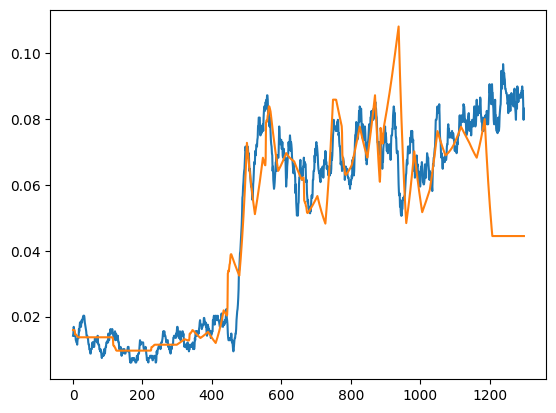

In [88]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr]-300)
    predicted_tr.append(rate_pred_train[start[i_tr]:end[i_tr]][st:int(st+300+1000)])
no_neu = np.where(neu_data.sample_id[mask][:s_on_train.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr]-300)
    dat = sp_train[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+300+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

In [89]:
ds_test=np.concatenate(all_ds[n_train_tr:])
sp_test=np.concatenate(all_sp[n_train_tr:])
len_tr_test=np.array(all_len_tr)[n_train_tr:]
s_on_test=np.array(all_s_on)[n_train_tr:]
rate_pred_test = np.exp(glm_const + ds_test@ glm_result.params[1:])

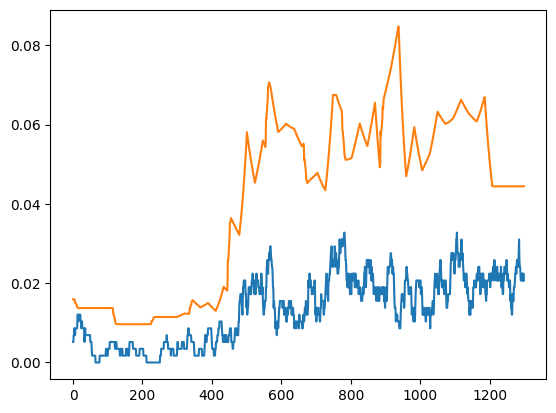

In [90]:
cumsum = np.cumsum(len_tr_test)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr]-300)
    predicted_tr.append(rate_pred_test[start[i_tr]:end[i_tr]][st:int(st+300+1000)])
no_neu = np.where(neu_data.sample_id[mask][:s_on_test.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr]-300)
    dat = sp_test[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+300+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

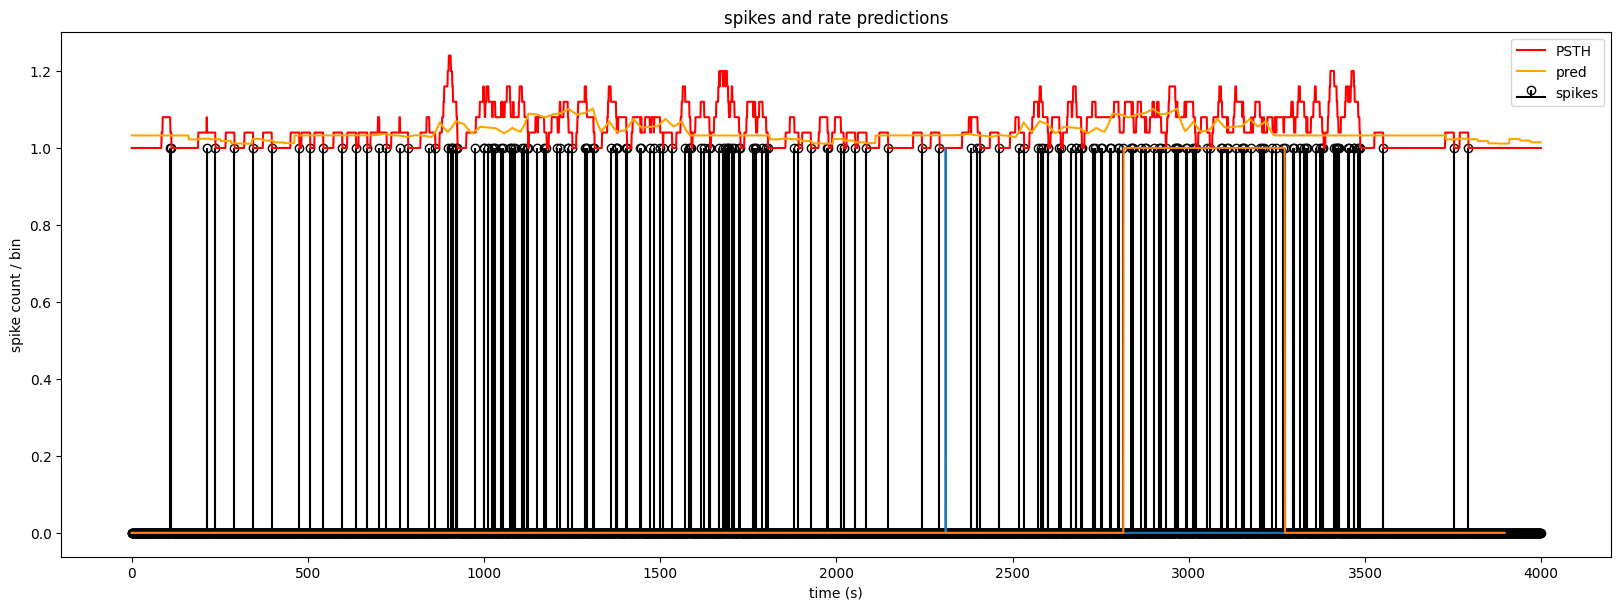

In [79]:
# Compute predicted spike rate on training data
#rate_pred = np.exp(glm_const + ds_train@ glm_result.params[1:])

# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,4000)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, sp_train[:4000][iiplot], linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_train[:4000]
plt.plot(ttplot,firing_rate.moving_average(data=dat, win=25, step = 1)+1, c='red', label='PSTH')
plt.plot(ttplot,rate_pred_train[:4000]+1, c='orange', label='pred')
_=plt.plot(fix_cue)
# _=plt.plot(fixation)
_=plt.plot(sample_on_off)
plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

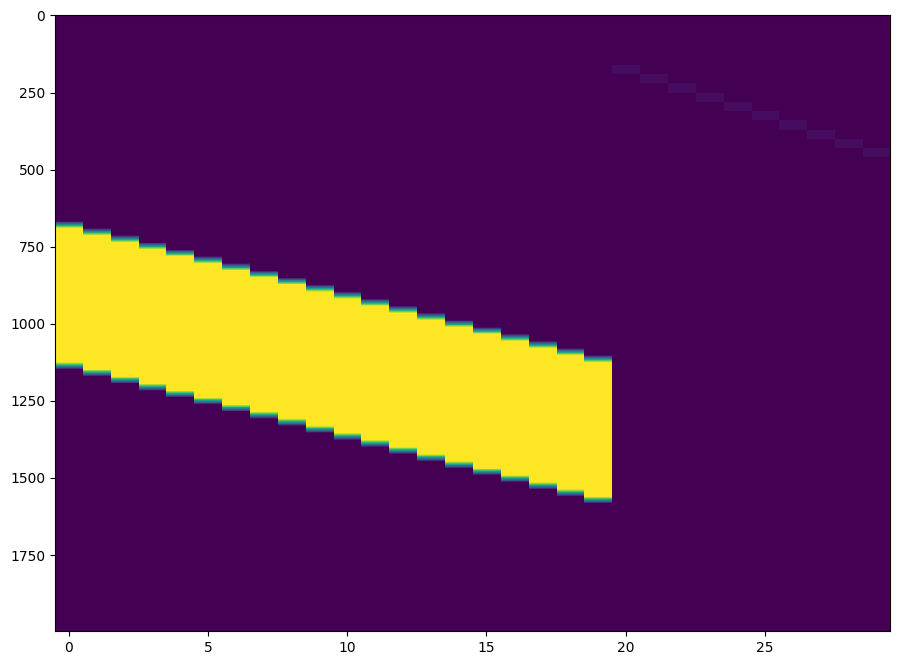

In [16]:
# Combine these into a single design matrix
design_mat = np.concatenate((a[:T], b[:T]), axis=1)
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(design_mat, aspect='auto', interpolation='nearest')